In [1]:
# #!pip install tf-nightly==2.5.0.dev20201111 -qqq --progress-bar off
# import tensorflow as tf
# print(tf.__version__)
# assert tf.__version__== '2.5.0-dev20201111','bad version'

In [2]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [3]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.mixture import BayesianGaussianMixture

from scipy.spatial.distance import pdist,squareform

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D


from sklearn.decomposition import PCA
import umap

print(now()-t00)

0:00:06.761230


In [4]:
import bc_mri_ae_utils
from bc_mri_ae_utils import *

In [5]:
project_data

<function bc_mri_ae_utils.project_data(data, dxArr, lbls, legend=True)>

In [6]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [7]:
# get abide dataframe
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [8]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [9]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

### Vanilla VAE with 32 dimensions

In [10]:
# get convolutional vae (CVAE)
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=32, batch_size=32, disentangle=False, gamma=1)#
#vae.load_weights('../tf_outputs/weights/lol');
vae.load_weights('/Users/aidasaglinskas/Downloads/drive-download-20201208T110626Z-001/Nov23_VAE_32DIM');

### Contrastive VAE with 16 dimensions in background encoder and 16 dimensions in salient

In [11]:
# get contrastive convolutional vae (CCVAE)
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(input_shape=(64, 64, 64, 1),latent_dim=16)
#weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
weights_fn = '../tf_outputs/3D_CCVAE_Weights/Nov23'
cvae.load_weights(weights_fn)

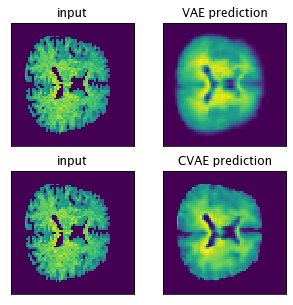

In [12]:
inMat = ABIDE_data[0:5,:,:,:];

plt.figure(figsize=(5,5));
plt.subplot(2,2,1);plt.imshow(ABIDE_data[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
plt.subplot(2,2,2);plt.imshow(vae.predict(inMat)[0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('VAE prediction');

plt.subplot(2,2,3);plt.imshow(ABIDE_data[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
plt.subplot(2,2,4);plt.imshow(cvae.predict([inMat,inMat])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('CVAE prediction');

### Reconstruction (in sample prediction) - both VAEs seem to have been fit well :)

In [13]:
arr = np.load('./Data/SFARI-Anat-64iso.npz')
SFARI_data = arr['data']
SFARI_subs = arr['subs']
snsubs = SFARI_data.shape[0]
print(arr.files)
SFARI_data.shape

['data', 'subs']


(131, 64, 64, 64)

In [14]:
ps_CCVAE = cvae.predict([SFARI_data[:,:,:,:],SFARI_data[:,:,:,:]])
ps_CVAE = vae.predict(SFARI_data[:,:,:,:])

In [15]:
print(ps_CVAE.shape)

(131, 64, 64, 64, 1)


Text(0.5, 1.0, 'VAE reconstruction')

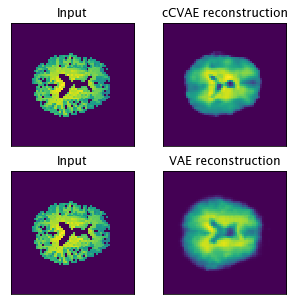

In [16]:
plt.figure(figsize=(5,5))
s = 25;k = 35
plt.subplot(2,2,1)
plt.imshow(SFARI_data[s,:,:,k]);plt.xticks([]);plt.yticks([]);plt.title('Input')
plt.subplot(2,2,2)
plt.imshow(ps_CCVAE[1][s,:,:,k,0]);plt.xticks([]);plt.yticks([]);plt.title('cCVAE reconstruction')

plt.subplot(2,2,3)
plt.imshow(SFARI_data[s,:,:,k]);plt.xticks([]);plt.yticks([]);plt.title('Input')
plt.subplot(2,2,4)
plt.imshow(ps_CVAE[s,:,:,k,0]);plt.xticks([]);plt.yticks([]);plt.title('VAE reconstruction')

### Out of sample prediction (train on ABIDE, reconstruct SFARI): reasonable reconstruction too

In [17]:
from sklearn.decomposition import PCA
import umap

def dim_reduce(z,method='UMAP'):
    
    if method=='UMAP':
        reducer = umap.UMAP()
    else:
        reducer = PCA(n_components=2)
        
    tiny = reducer.fit_transform(z)
    
    return tiny

In [18]:
# encoders 
t0 = now()
encs = [z_encoder, s_encoder ,encoder] # background, salient, vae

# Indices
patients = df['DxGroup'].values==1 # ASD
controls = df['DxGroup'].values==2 # controls
all_subs = patients+controls

# data in 
data = ABIDE_data

# spaces 
w = 2 # 0 - mean, 1 - std - 2 - sample
bg_space = np.array(encs[0](data)[w])
sl_space = np.array(encs[1](data)[w])
vae_space = np.array(encs[2](data)[w])

##### dim reduce
do_dimRed=True
if all((do_dimRed,bg_space.shape[1]>2)):
    method = 'UMAP'
    bg_space = dim_reduce(bg_space,method=method)
    sl_space = dim_reduce(sl_space,method=method)
    vae_space = dim_reduce(vae_space,method=method)

spaces = [bg_space,sl_space,vae_space]
spaces_ASD = [bg_space[patients,:],sl_space[patients,:],vae_space[patients,:]]
spaces_TD = [bg_space[controls,:],sl_space[controls,:],vae_space[controls,:]]

print(str(now()-t0))

0:00:55.725408


In [19]:
def cscatter(spaces,v=None,c=None,clim=None,clbl=None,legend=None):
    space_lbls = ['Background','Salient','VAE']

    if type(v)==type(None):
        v = np.repeat(True,len(spaces[0]))
        
    plt.figure(figsize=(12,4))
    for i in range(len(spaces)):
        plt.subplot(1,3,i+1)
        
        if type(c)!=type(None) and len(np.unique(c)) > 10: # continus colourbar
            #print('continuues colourbar')
            
            plt.scatter(spaces[i][v,0],spaces[i][v,1],c=c)
            if type(clim)==type(None): #if clim not passed, 
                clim = (min(c),max(c)) # calc min max
            plt.clim(clim[0],clim[1]) # do clim regardless
                
            cbar = plt.colorbar()
            cbar.ax.set_ylabel(clbl,rotation=270,labelpad=20,fontsize=16,fontweight='bold')    
                
        elif type(c)!=type(None) and len(np.unique(c)) < 10: # categorical colourbar
            #print('categorical colourbar')
            for j in np.unique(c):
                plt.scatter(spaces[i][c[v]==j,0],spaces[i][c[v]==j,1],alpha=.5)
                    
            if type(legend)==type(None):
                legend = [str(i) for i in np.unique(c)]    
            plt.legend(legend)

        else:
           #print('else')
            plt.scatter(spaces[i][v,0],spaces[i][v,1])
            
        
        #plt.scatter(spaces[i][v,0],spaces[i][v,1],c=c)
        plt.xlabel('latent dim. 1');plt.ylabel('latent dim. 2')
        plt.title(space_lbls[i])

    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.3,hspace=None,) 
    print(sum(v))

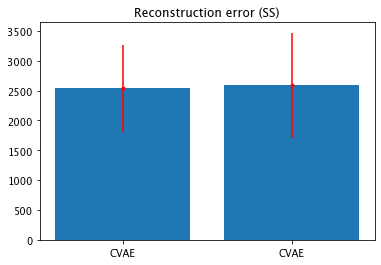

In [20]:
v1 = np.array([((SFARI_data[s,:,:,:]-ps_CCVAE[0][s,:,:,:,0])**2).sum() for s in range(100)])
v2 = np.array([((SFARI_data[s,:,:,:]-ps_CVAE[s,:,:,:,0])**2).sum() for s in range(100)])

xs = np.arange(2)
y = [v1.mean(),v2.mean()]
se = [v1.std(),v2.std()]
plt.bar(xs,y)
plt.errorbar(xs,y,se,fmt='r.')

plt.xticks(xs,labels=['CVAE','CVAE']);
plt.title('Reconstruction error (SS)');

### Reconstruction losses (calculated on SFARI) - no significant differnces in between VAE and cVAE - we can proceed to compare them. 

# Laten Space Clusters

982


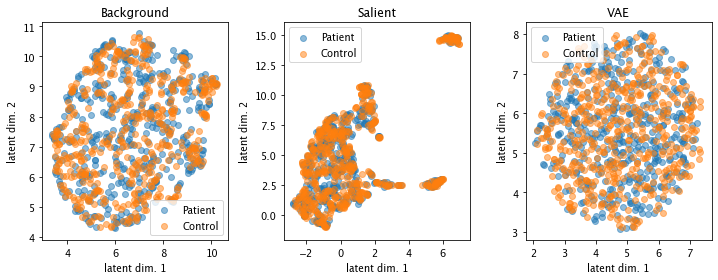

In [21]:
diag_lbl = df['DxGroup'].values[all_subs]
cscatter(spaces,v=all_subs,c=diag_lbl,legend=['Patient','Control'])

### Do these networks inherently discover overall differences between ASD and TD? No - none if them do (silhouette scores close to zero)

470


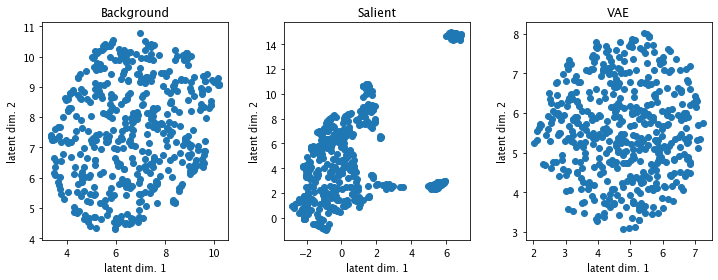

In [22]:
cscatter(spaces_ASD)

In [23]:
print('running BNPC');t0 = now()

v = patients
print('clustering background')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_bg = bnpc.fit_predict(spaces[0][v,:]);print(now()-t0)
print('clustering salient')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_sl = bnpc.fit_predict(spaces[1][v,:]);print(now()-t0)

print('clustering vae')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_vae = bnpc.fit_predict(spaces[2][v,:]);print(now()-t0)

print('all done')

running BNPC
clustering background
0:01:06.157944
clustering salient
0:01:34.062063
clustering vae
0:02:34.737322
all done


470


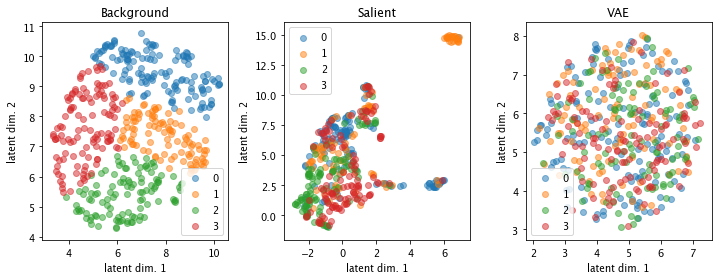

In [24]:
cscatter(spaces_ASD,c=cid_bg)

### Clustering on background space: BNP finds four clusters but silhoutte scores show that these clusters are not distinct at all.

470


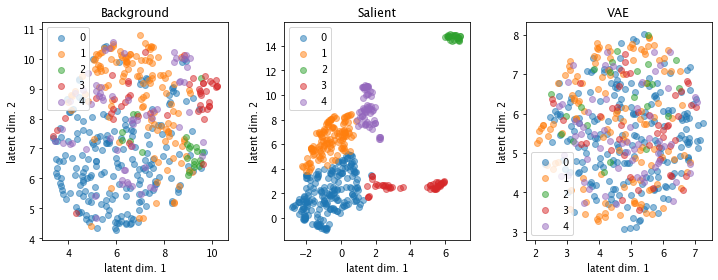

In [25]:
cscatter(spaces_ASD,c=cid_sl)

### Clustering on Salient space shows 5 clusters, silhoutte scores show that they are distinct; this clustering structure is not present in either background or VAE

470


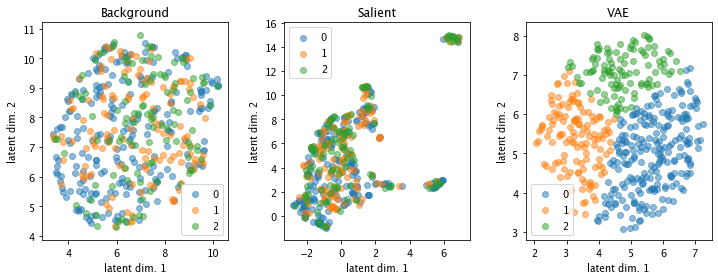

In [26]:
cscatter(spaces_ASD,c=cid_vae)

0.3333333333333333

In [176]:
nbars = 3

In [180]:
i = 0


array([-0.33333333,  0.        ,  0.33333333])

In [215]:
def plot_groupBar(arr):
    colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
     (1.0, 0.4980392156862745, 0.054901960784313725),
     (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
     (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
     (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]
    for i in range(arr.shape[1]):
        x = i+1;
        plt.bar(i-.33,arr[0,i],color=colors[0],width=.33);
        plt.bar(i+.0,arr[1,i],color=colors[1],width=.33);
        plt.bar(i+.33,arr[2,i],color=colors[2],width=.33);

    plt.xticks(np.arange(arr.shape[1]),labels=targ_RDM_labels);
    plt.legend(['cid_bg','cid_sl','cid_vae'])

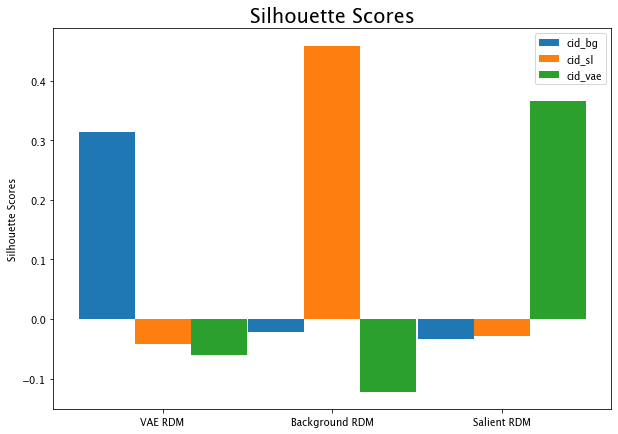

In [221]:
plt.figure(figsize=(10,7))
a = np.array([[silhouette_score(spaces_ASD[0],lbl) for lbl in (cid_bg,cid_sl,cid_vae)],
[silhouette_score(spaces_ASD[1],lbl) for lbl in (cid_bg,cid_sl,cid_vae)],
[silhouette_score(spaces_ASD[2],lbl) for lbl in (cid_bg,cid_sl,cid_vae)]]);

plot_groupBar(a);
plt.title('Silhouette Scores',fontsize=20);
plt.ylabel('Silhouette Scores');

## SFARI data 

In [222]:
dfs = pd.read_csv('./CSVs/DS-use.csv')
dfs = dfs.iloc[np.array([l in SFARI_subs for l in dfs['BIDS ID'].values])]

assert all([dfs['BIDS ID'].values[i]==SFARI_subs[i] for i in range(snsubs)]),'badness'
assert len(dfs)==len(SFARI_subs),'bad coder, bad!'

# SLICE: Only Keep 16p and TD
ugene = ['non-familial-control','16p-duplication','16p-deletion']
slice_arr = np.array([val in ugene for val in dfs['family_type'].values])

dfs = dfs.iloc[slice_arr]
snsubs = len(dfs)
SFARI_data = SFARI_data[slice_arr,:,:,:]
SFARI_subs = SFARI_subs[slice_arr]
print(snsubs)

121


In [223]:
dfs.head()

,BIDS ID,SVIP ID,FCAP1,SCAP1,SCAP2,family_type,genetic_status_16p,svip_diagnosis_m1,ados_css,ados_module,...,relationship_to_iip,rrb_css,sa_css,sex,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,age_years
0,sub-004,14705.x14,14705.x14_50_FCAP1,14705.x14_40_SCAP1,[],16p-duplication,duplication,no-diagnosis,2,ados-4,...,Mother,1,2,female,[],[],[],405,svip-neuro-exam,34
1,sub-008,14708.x10,14708.x10_60_FCAP1,14708.x10_40_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,2,ados-3,...,Initially identified proband,1,3,female,54.8,[],2.08,113,svip-neuro-exam,9
2,sub-012,14713.x7,14713.x7_50_FCAP1,14713.x7_30_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,6,ados-3,...,Initially identified proband,5,7,male,55.2,[],2.28,87,svip-neuro-exam,7
3,sub-014,14714.x18,14714.x18_60_FCAP1,14714.x18_40_SCAP1,[],16p-deletion,deletion,no-diagnosis,2,ados-4,...,Initially identified proband,6,2,male,55.8,[],0.49,249,svip-neuro-exam,21
4,sub-018,14718.x5,14718.x5_50_FCAP1,14718.x5_20_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,1,ados-3,...,Initially identified proband,1,1,female,54,[],1.15,127,svip-neuro-exam,11


In [224]:
geneVec = np.repeat(0,snsubs)
geneVec[dfs['family_type'].values==ugene[0]]=1
geneVec[dfs['family_type'].values==ugene[1]]=2
geneVec[dfs['family_type'].values==ugene[2]]=3

In [30]:
# encoders 
t0 = now()

# data in 
data = SFARI_data

# spaces 
bg_space_sfari = np.array(encs[0](data)[w])
sl_space_sfari = np.array(encs[1](data)[w])
vae_space_sfari = np.array(encs[2](data)[w])

##### dim reduce
do_dimRed=True
if all((do_dimRed,bg_space_sfari.shape[1]>2)):
    method = 'UMAP'
    bg_space_sfari = dim_reduce(bg_space_sfari,method=method)
    sl_space_sfari = dim_reduce(sl_space_sfari,method=method)
    vae_space_sfari = dim_reduce(vae_space_sfari,method=method)

spaces_sfari = [bg_space_sfari,sl_space_sfari,vae_space_sfari]
print(str(now()-t0))

0:00:08.199050


121


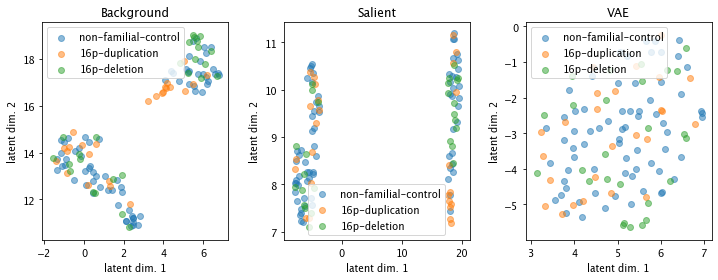

In [31]:
cscatter(spaces_sfari,c=geneVec,legend=ugene)

51


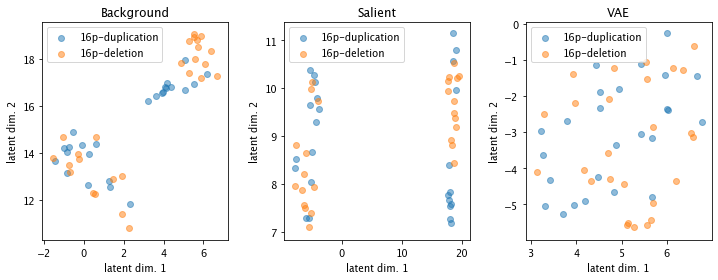

In [32]:
v = geneVec!=1
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=geneVec[v],legend=ugene[1::])

### On an independent dataset (SFARI), VAE shows lack of any clustering, background and salient show two distinct clusters, but it's unclear what's the axis of clustering

In [33]:
print('running BNPC');t0 = now()

v = geneVec!=1

print('clustering background')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_bg_sfari = bnpc.fit_predict(spaces_sfari[0][v,:]);print(now()-t0)
print('clustering salient')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_sl_sfari = bnpc.fit_predict(spaces_sfari[1][v,:]);print(now()-t0)
print('clustering vae')
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=25,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=1,weight_concentration_prior_type='dirichlet_process')
cid_vae_sfari = bnpc.fit_predict(spaces_sfari[2][v,:]);print(now()-t0)

print('all done')

running BNPC
clustering background
0:00:04.954685
clustering salient
0:00:13.241342
clustering vae
0:00:27.240000
all done


51


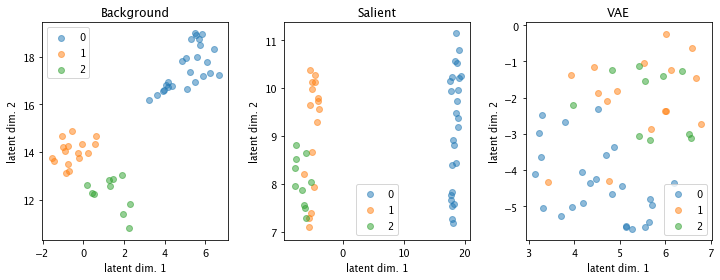

In [34]:
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=cid_bg_sfari)

51


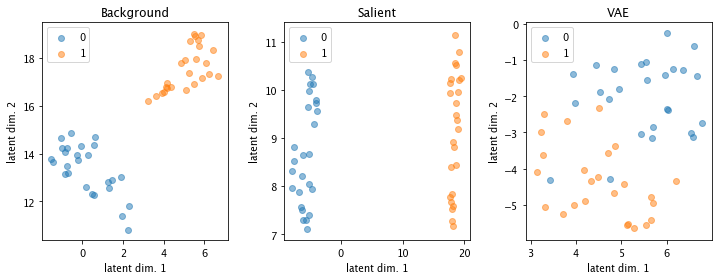

In [35]:
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=cid_sl_sfari)

### SFARI BNP clustering defined on salient features

51


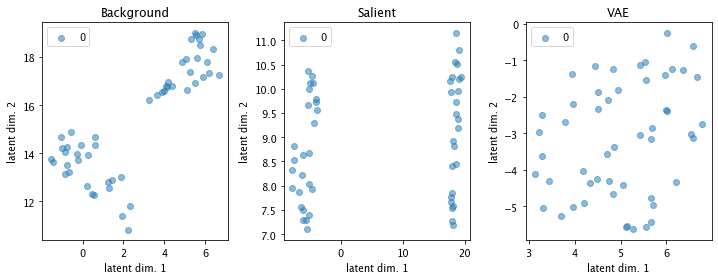

In [36]:
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=cid_vae_sfari)

### SFARI BNP clustering defined on VAE features

In [229]:
df_man = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-ASD-FC/Excel/sfari_manufacturers.csv')
idx = np.array([df_man['bids id'].values[s] in dfs['BIDS ID'].values for s in range(len(df_man))])
df_man = df_man.iloc[idx]

assert len(dfs)==len(df_man)
assert all([dfs['BIDS ID'].values[s]==df_man['bids id'].values[s] for s in range(len(dfs))])

df_man['family_type'] = dfs['family_type']

In [233]:
df_man.groupby(['man','family_type']).count()

Unnamed: 0  bids id  svip id
man                     family_type                                       
Philips Medical Systems 16p-deletion                  20       20       20
                        16p-duplication               18       18       18
SIEMENS                 16p-deletion                   5        5        5
                        16p-duplication                6        6        6
                        non-familial-control          55       55       55
unknown                 16p-deletion                   1        1        1
                        16p-duplication                1        1        1
                        non-familial-control          15       15       15

104


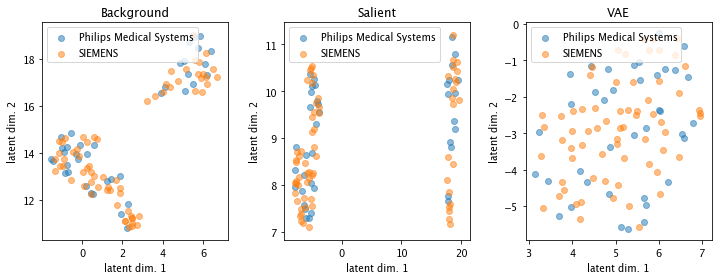

In [38]:
#v = geneVec!=1
v=df_man['man'].values!='unknown'
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=numerize(df_man['man'][v]),legend=np.unique(df_man['man'].values[v]))

51


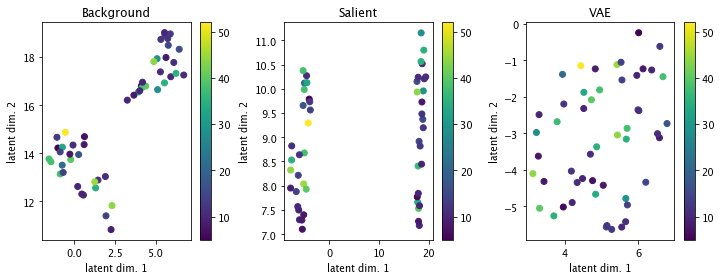

In [39]:
v = geneVec!=1
cscatter([bg_space_sfari[v,:],sl_space_sfari[v,:],vae_space_sfari[v,:]],c=dfs['age_years'][v])

### Using independent SFARI data it seems that cVAE find features that transfer to a new dataset (although what these features are is unclear), VAE does not show any systematicity in the independent dataset (but it also showed no systematicity in the training set, in sample, ABIDE, either)

In [40]:
from importlib import reload
import bc_mri_ae_utils
reload(bc_mri_ae_utils)
from bc_mri_ae_utils import *

In [41]:
# # Age and Gender matched del and dupl subjects
# # Salient space seems to better differentiate them (only 4 subjects though)
# dd = np.zeros(snsubs)
# v1 = dfs['family_type'].values=='16p-deletion'
# v2 = dfs['age_years'].values < 30
# targ = v1*v2
# ccidx = np.array(getCaseMatch(targ,dfs,do_plot=True))
# dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
# #project_data(SFARI_data[d,:,:,:],dd[d],['DUPL','DEL'])

### Matching 16p DEL and DUPL subjects, there's no differences (the numbers below .2 can change due to RNG sampling)

In [42]:
# # Case matched ASD and TD subjects (all have 16p-deletion) 
# # No clear differentiation

# dd = np.zeros(snsubs)
# v1 = dfs['clinical_asd_dx'].values=='1'
# v2 = dfs['age_years'].values < 35
# targ = v1
# ccidx = np.array(getCaseMatch(targ,do_plot=False,control=ugene[2]))
# dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
# project_data(SFARI_data[d,:,:,:],dd[d],['ASD','TD']);plt.ylim(.0,1)

### Age and gender matched 16p DEL subjects with and without ASD - no difference between spaces 

### ALTERNATIVE EXPLANATIONS OF CLUSTERING (ABIDE)

### Are the representational spaces organised by meaningful variables such as age, gender, brain size or asd diagnosis? or by known confounds such as scanning site or scanner type? Scanning site and scanner type are known to have very strong effects

In [43]:
space_bg_abide = bg_space
space_sl_abide = sl_space
space_vae_abide = vae_space

### In the following plots I coloured the dots by different variables, noted on the colourbar axis. (only ASD subjects are plotted)

470


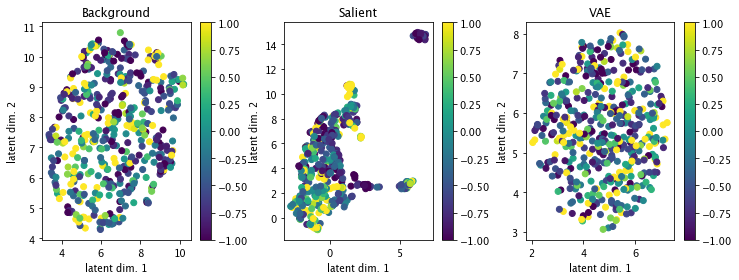

In [44]:
# Dots coloured by age (z scored)
ages = df['AgeAtScan'].values
agesz = (ages-ages.mean())/ages.std()
cscatter(spaces_ASD,c=agesz[patients],clim=(-1,1))

### Age (z scores), colour treshold set at (-1,1) for ease of interpretability

470


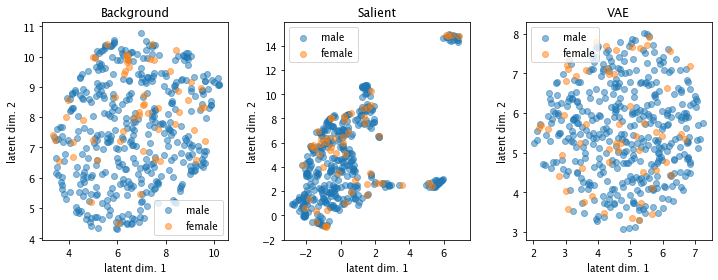

In [45]:
# Dots coloured by gender. 1=Male, 2=Female
gender = df['Sex'].values
cscatter(spaces_ASD,c=gender[patients],legend=['male','female'])

### Gender (1=Male, 2=Female)

470


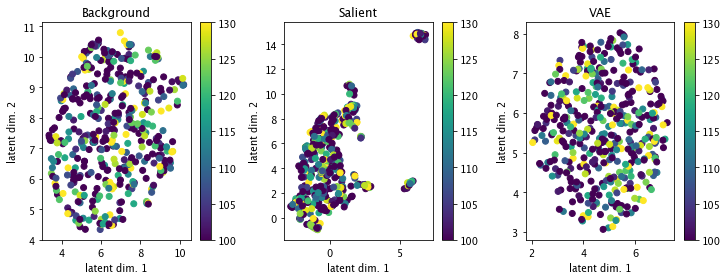

In [46]:
# Dots coliured by FIQ (Fluid IQ?)
fiq = df['FIQ'].values
fiq[abs(df['FIQ'].values)>200]=np.nan
cscatter(spaces_ASD,c=fiq[patients],clim=(100,130))

### FIQ (Fluid IQ)

470


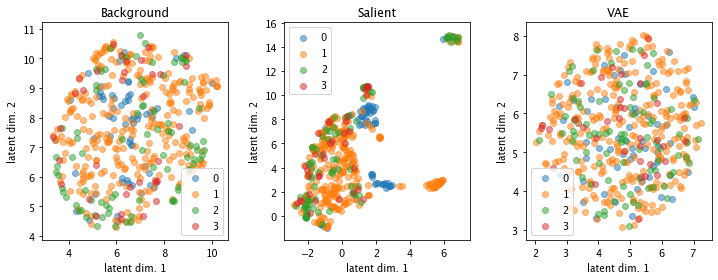

In [47]:
# DSM IV ASD categories
def str2num(val):
    try:
        return int(val)
    except:
        return 0

DSMIVTR = [str2num(val) for val in df['DSMIVTR'].values]
DSMIVTR = np.array(DSMIVTR)

cscatter(spaces_ASD,c=DSMIVTR[patients])

### DSM diagnostic category, some apparent clustering in the salient space, but the subjects in some of the clusters also come from different scanners; so this effect can also be explained by scanner type and scanning site effects

470


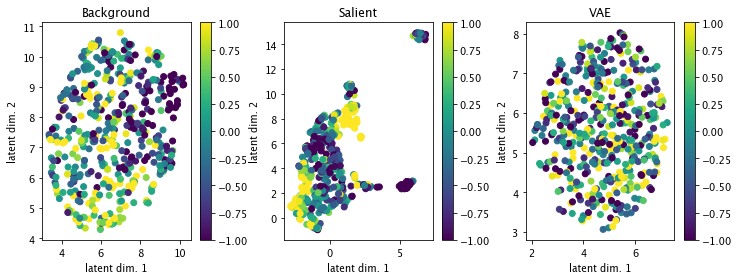

In [48]:
# Brain volume
head_size = np.array(np.reshape(ABIDE_data,(ABIDE_data.shape[0],-1))>.02).sum(axis=1)
head_sizez = (head_size-head_size.mean())/head_size.std()
#plot_cscatter(head_sizez,clbl='brain size (z)',clim=(-1,1),v=controls)
cscatter(spaces_ASD,c=head_sizez[patients],clim=(-1,1))

### Brain volume (calculated from the MPRAGE images), some effect on clustering in salient and maybe background spaces?

In [49]:
# Get Scanner Types and Scanning Site
df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [50]:
center = [line.split('/')[6] for line in df2['sub_path'].values]
scanner = [line.split('/')[8] for line in df2['sub_path'].values]

470
['achieva' 'allegra' 'discovery_mr750' 'intera'
 'magnetom_allegra_syngo_mr_a30' 'signa' 'triotim' 'verio']


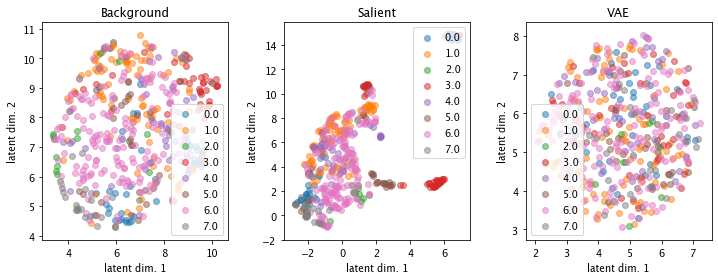

In [51]:
# Scanner type
cscatter(spaces_ASD,c=numerize(scanner)[patients])
print(np.unique(scanner))

### Scanner type effects: Strong effects on clustering in background and salient spaces. Some clusters in salient space are from distinct scanners. However, it's not that all subjects from a single scanner are that cluster. Therefore, scanning site alone can't explain the clustering, and the silhouette scores are low (not plotted)

470
['caltech' 'kki' 'kul' 'mpg' 'nyu' 'ohsu' 'olin' 'pitt' 'sbl' 'sdsu' 'sjh'
 'stanford' 'ucla' 'um' 'usm' 'yale']


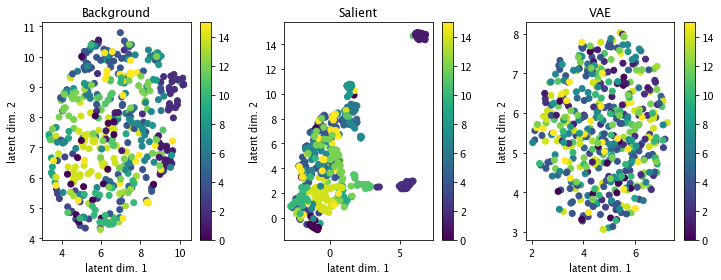

In [52]:
# Scanning center
cscatter(spaces_ASD,c=numerize(center)[patients])
print(np.unique(center))

# RSA analyses

### Instead of using silouette scores, which is a somewhat crude measure, let's use RSA to ask if people that are similar in brain size are represented similarly in the cVAE and VAE spaces

In [53]:
dist_met = 'euclidean' # Euclidean distance for all measures
print(dist_met)

euclidean


In [54]:
def norm(mat):
    return (mat-mat.min())/(mat.max()-mat.min())

In [55]:
v = patients
RDM_age = norm(1-squareform(pdist(agesz[v][:,np.newaxis],metric=dist_met)))
RDM_gender  = norm(1-squareform(pdist(gender[v][:,np.newaxis],metric=dist_met)))
RDM_fiq  = norm(1-squareform(pdist(fiq[v][:,np.newaxis],metric=dist_met)))
RDM_dsm  = norm(1-squareform(pdist(DSMIVTR[v][:,np.newaxis],metric=dist_met)))
RDM_headsize  = norm(1-squareform(pdist(head_sizez[v][:,np.newaxis],metric=dist_met)))

In [56]:
modelRDMs = [RDM_age, RDM_gender, RDM_dsm, RDM_headsize]
modelRDM_titles = ['Age RDM','Gender RDM', 'DSM RDM', 'Brain vol RDM']

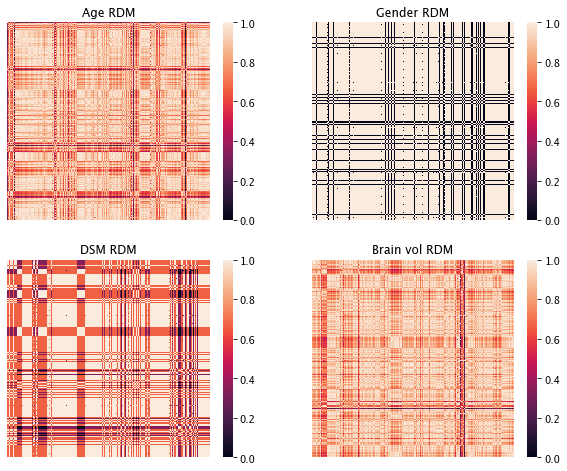

In [57]:
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.heatmap(modelRDMs[i])
    plt.xticks([]);plt.yticks([])
    plt.title(modelRDM_titles[i])

## RDM plots of Age, Gender, DSM and brain volume

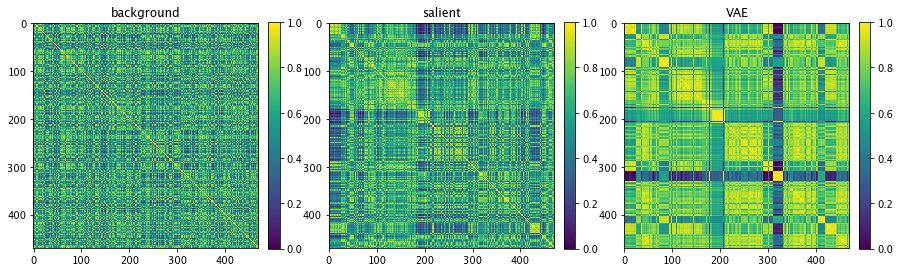

In [58]:
v = patients
#v = controls
RDM_vae = norm(1-squareform(pdist(space_vae_abide[v], metric=dist_met)))
RDM_bg = norm(1-squareform(pdist(space_bg_abide[v], metric=dist_met)))
RDM_sl = norm(1-squareform(pdist(space_sl_abide[v], metric=dist_met)))

targ_RDMs = [RDM_vae,RDM_bg,RDM_sl]
targ_RDM_labels = ['VAE RDM','Background RDM','Salient RDM']

space_lbls = ['background','salient','VAE']
mats = [RDM_vae,RDM_bg,RDM_sl]
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    mat = mats[i]
    plt.imshow(mat)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(space_lbls[i])

### Background, Salient and VAE RDM plots for ASD subjects (euclidean distance) Weirdly, there is seemingly no systematic structure in the background space; Might be a bug, I'd expect background and VAE to capture similar features

In [59]:
def triu(inMat):
    '''return upper triangle values'''
    assert inMat.shape[0]==inMat.shape[1], 'mat not symetrical'
    n = inMat.shape[0]
    vec = inMat[np.triu_indices(n,1)]
    return vec

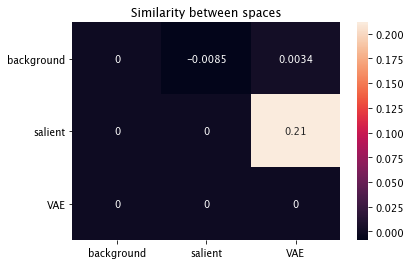

In [60]:
sim = np.corrcoef(np.array([triu(mat) for mat in mats]))
sim = np.triu(sim,k=1)
sns.heatmap(sim,annot=True);
plt.xticks(np.arange(sim.shape[0])+.5,labels=space_lbls);
plt.yticks(np.arange(sim.shape[0])+.5,labels=space_lbls,rotation=0);
plt.title('Similarity between spaces');

### Similarity between the spaces: low similarity between them

In [61]:
def plot_groupBar(arr):
    colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
     (1.0, 0.4980392156862745, 0.054901960784313725),
     (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
     (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
     (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]
    for i in range(arr.shape[1]):
        x = i+1;
        plt.bar(i-.25,arr[0,i],color=colors[0],width=.45);
        plt.bar(i+.25,arr[1,i],color=colors[1],width=.45);

    plt.xticks(np.arange(arr.shape[1]),labels=targ_RDM_labels);
    plt.legend(['TD','ASD'])

[(470, 470), (470, 470), (470, 470), (470, 470)]
[(470, 470), (470, 470), (470, 470)]


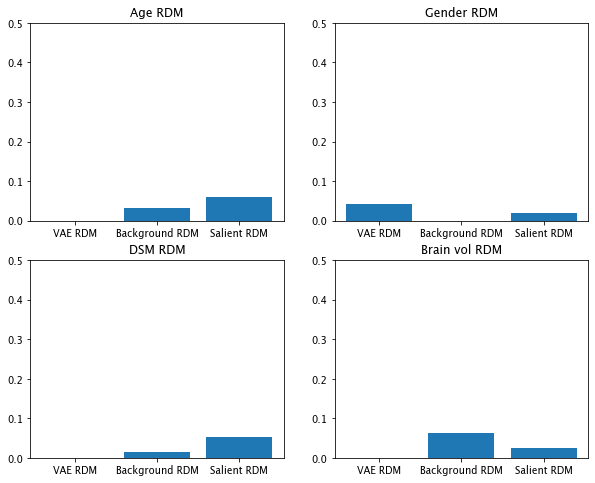

In [62]:
targ_RDMs = [RDM_vae,RDM_bg,RDM_sl]
targ_RDM_labels = ['VAE RDM','Background RDM','Salient RDM']

modelRDMs = [RDM_age, RDM_gender, RDM_dsm, RDM_headsize]
modelRDM_titles = ['Age RDM','Gender RDM', 'DSM RDM', 'Brain vol RDM']

print([m.shape for m in modelRDMs])
print([t.shape for t in targ_RDMs])

nTarg = len(targ_RDMs)
nModel = len(modelRDMs)
rsa_res = np.zeros((nTarg,nModel))

for t in range(nTarg):
    for m in range(nModel):
        rsa_res[t,m] = np.corrcoef(triu(targ_RDMs[t]),triu(modelRDMs[m]))[0,1]
        
plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.bar(np.arange(nTarg),rsa_res[:,i])
    plt.xticks(np.arange(nTarg),targ_RDM_labels)
    plt.title(modelRDM_titles[i])
    plt.ylim(0,.5)

### Salient space uniquely tracks similarity between ASD patients in age & DSM diagnosis. Salient and background are sensitive to ASD patient brain size. Reliability of this results, across sampling (rng) remains to be established though

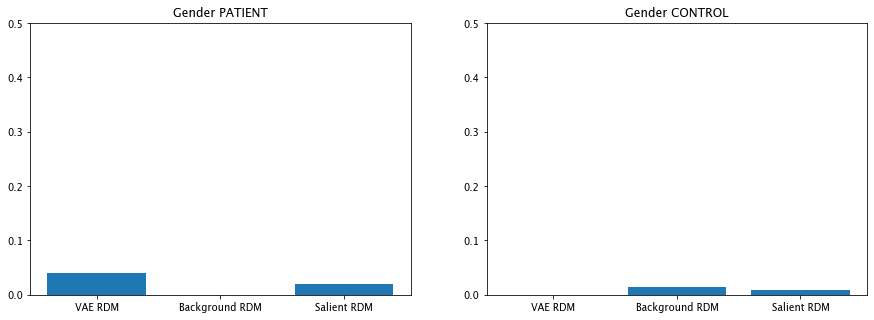

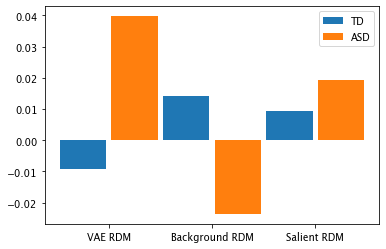

In [63]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
vv = np.array(df['Subject Type'].values=='CONTROL') #* ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['Sex'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr1)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender CONTROL')
plt.ylim(0,.5)

plt.subplot(1,2,1)
vv = np.array(df['Subject Type'].values=='PATIENT') #* ~np.isnan(df['FIQ'].values)
m = triu(norm(1-squareform(pdist(df['Sex'].values[vv][:,np.newaxis],metric=dist_met))))
T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
plt.bar([0,1,2],arr2)
plt.xticks(np.arange(nTarg),targ_RDM_labels)
plt.title('Gender PATIENT')
plt.ylim(0,.5)

plt.figure()
plot_groupBar(np.vstack((arr1,arr2)))

### Gender RSA results too tiny to be meaningful

In [64]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,2)
# vv = np.array(df['Subject Type'].values=='CONTROL') * ~np.isnan(df['FIQ'].values)
# m = triu(norm(1-squareform(pdist(df['FIQ'].values[vv][:,np.newaxis],metric=dist_met))))
# T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
# arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
# plt.bar([0,1,2],arr1)
# plt.xticks(np.arange(nTarg),targ_RDM_labels)
# plt.title('Gender CONTROL')
# plt.ylim(0,.5)

# plt.subplot(1,2,1)
# vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
# m = triu(norm(1-squareform(pdist(df['FIQ'].values[vv][:,np.newaxis],metric=dist_met))))
# T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
# arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
# plt.bar([0,1,2],arr2)
# plt.xticks(np.arange(nTarg),targ_RDM_labels)
# plt.title('Gender PATIENT')
# plt.ylim(0,5)

# plt.figure()
# plot_groupBar(np.vstack((arr1,arr2)))

In [65]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,2)
# vv = np.array(df['Subject Type'].values=='CONTROL') * ~np.isnan(df['FIQ'].values)
# m = triu(norm(1-squareform(pdist(df['AgeAtScan'].values[vv][:,np.newaxis],metric=dist_met))))
# T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
# arr1 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
# plt.bar([0,1,2],arr1)
# plt.xticks(np.arange(nTarg),targ_RDM_labels)
# plt.title('AgeAtScan CONTROL')
# plt.ylim(0,.5)

# plt.subplot(1,2,1)
# vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
# m = triu(norm(1-squareform(pdist(df['AgeAtScan'].values[vv][:,np.newaxis],metric=dist_met))))
# T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
# arr2 = np.array([np.corrcoef(m,T[i,:])[0,1] for i in range(3)])
# plt.bar([0,1,2],arr2)
# plt.xticks(np.arange(nTarg),targ_RDM_labels)
# plt.title('AgeAtScan PATIENT')
# plt.ylim(0,.5)

# plt.figure()
# plot_groupBar(np.vstack((arr1,arr2)))

### Salient space is sensitive to age in both ASD and controls, background space only for controls

In [66]:
# #vv = np.array(df['Subject Type'].values=='PATIENT') * ~np.isnan(df['FIQ'].values)
# vv = all_subs
# RDM_dsm  = norm(1-squareform(pdist(DSMIVTR[vv][:,np.newaxis],metric=dist_met)))
# m = triu(RDM_dsm)
# T = np.array([1-triu(norm(squareform(pdist(space[vv], metric=dist_met)))) for space in [space_vae_abide,space_bg_abide,space_sl_abide]])
# plt.bar([0,1,2],arr2)
# plt.xticks(np.arange(nTarg),targ_RDM_labels)
# plt.title('DSM category')
# plt.ylim(0,.5)

### Salient space is sensitive to DSM category

## Prediction analyses. Using the latent-representations in each of the spaces (background, salient, and VAE) can we predict person's various attributes?

In [67]:
bv = dict()
bv['center'] = np.array(center)
bv['scanner'] = np.array(scanner)
bv['head_size'] = np.array(head_size )
bv['head_sizez'] = np.array(head_sizez)
bv['DSMIVTR'] = np.array(DSMIVTR)
bv['fiq'] = np.array(fiq)
bv['gender'] = np.array(gender)
bv['agesz'] = np.array(agesz)
bv['diag'] = np.array(controls*1)+np.array(patients*2)

In [68]:
def tabulate(vec):
    u = np.unique(vec)
    n = len(u)
    tab = np.zeros((n,2))

    for i in range(n):
        #tab[i,0] = u[i]
        tab[i,0] = sum(vec==u[i])
        tab[i,1] = sum(vec==u[i])/len(vec)
        
        tab[i,1] = tab[i,1].round(3)
        tab[i,0] = int(tab[i,0])

    f = pd.DataFrame(columns=['name','count','perc'])
    f['name']=u;f['count']=tab[:,0];f['perc']=tab[:,1]
    f = f.sort_values('count',ascending=False)
    f.head()
    return f

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_ind


from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
def fit_clf(y,vv):
    #spaces = [space_vae_abide,space_bg_abide,space_sl_abide]
    spaces = [space_vae_abide,space_bg_abide,space_sl_abide,np.hstack((space_bg_abide,space_sl_abide))]
    accs,ses,arrs = list(),list(),list()
    for x in spaces:
        x = x[vv]
        #clf = KNeighborsClassifier(n_neighbors=15)
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='lbfgs', max_iter=10000, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
        clf.fit(x,y)
        res = cross_validate(clf, x, y, cv=3)['test_score']
        
        arrs.append(res)
        acc = res.mean()    
        se = res.std()
        accs.append(acc)
        ses.append(se)

    plt.bar(np.arange(len(spaces)),accs);
    plt.errorbar(np.arange(len(spaces)),accs,ses,fmt='r.')
    plt.xticks(np.arange(len(spaces)),labels=['vae','bg','sl','bg+sl']);
    
    balanced=True
    if balanced:
        plt.plot(np.arange(-.5,len(spaces)+.5),np.repeat(1/len(np.unique(y)),len(spaces)+1),'k-.',alpha=.3)
    else:    
        plt.plot(np.arange(-.5,len(spaces)+.5),np.repeat(tabulate(y)['perc'].values.max(),len(spaces)+1),'k-.',alpha=.3)

Text(0.5, 1.0, 'DX: Children')

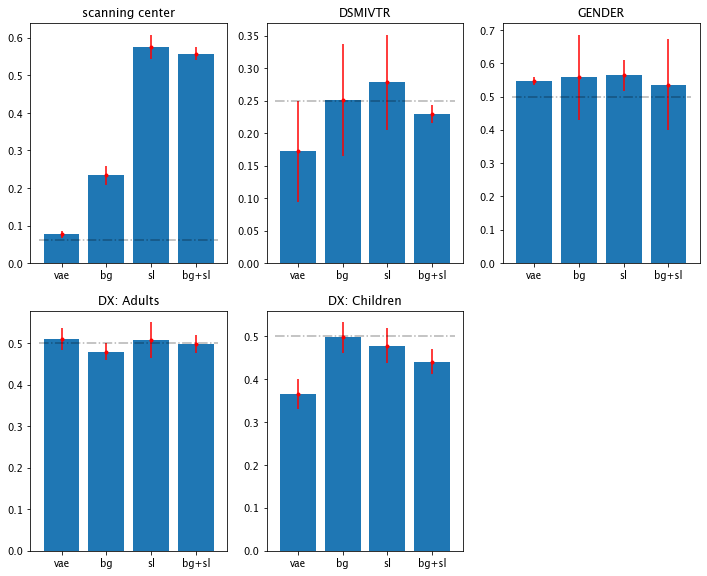

In [72]:
plt.figure(figsize=(12,15))
plt.subplot(3,3,1);vv = patients;y = numerize(bv['center'])[vv];fit_clf(y,vv);plt.title('scanning center')
plt.subplot(3,3,2);vv = patients*df['AgeAtScan'].values > 0;y = numerize(bv['DSMIVTR'])[vv];fit_clf(y,vv);plt.title('DSMIVTR')

plt.subplot(3,3,3);vv = patients*df['AgeAtScan'].values > 0;y = numerize(bv['gender'])[vv];fit_clf(y,vv);plt.title('GENDER')

plt.subplot(3,3,4);vv = (all_subs*df['AgeAtScan'].values > 18)*df['Sex'].values!=3;y = numerize(bv['diag'])[vv];fit_clf(y,vv);plt.title('DX: Adults')
plt.subplot(3,3,5);vv = (all_subs*df['AgeAtScan'].values < 12)*df['Sex'].values==1;y = numerize(bv['diag'])[vv];fit_clf(y,vv);plt.title('DX: Children')

Classification method; using latent-feature representations, l2 penalized logistic regression was trained to predict various attributes. Classifier was crossvalidated using 3 fold crossval. Errorbars show st dev across folds. regression weights were balanced to combat imbalances between classes. Dashed line shows chance level (if classifier were to guess the most common class only)

## Only the scanning site can be predicted above chance. and VAE space doesn't even do that. Possible problem? Looking into this

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression

def fit_reg(y,vv):
    spaces = [space_vae_abide,space_bg_abide,space_sl_abide,np.hstack((space_bg_abide,space_sl_abide))]
    accs,ses,arrs = list(),list(),list()
    for x in spaces:
        x = x[vv]
        clf = LinearRegression()
        mse = ((clf.fit(x,y).predict(x)-y)**2).mean()
        accs.append(1-mse/((y-y.mean())**2).mean())
    plt.bar(np.arange(len(spaces)),accs);
    plt.xticks(np.arange(len(spaces)),labels=['vae','bg','sl','both']);

dict_keys(['center', 'scanner', 'head_size', 'head_sizez', 'DSMIVTR', 'fiq', 'gender', 'agesz', 'diag'])


(0.1, 1)

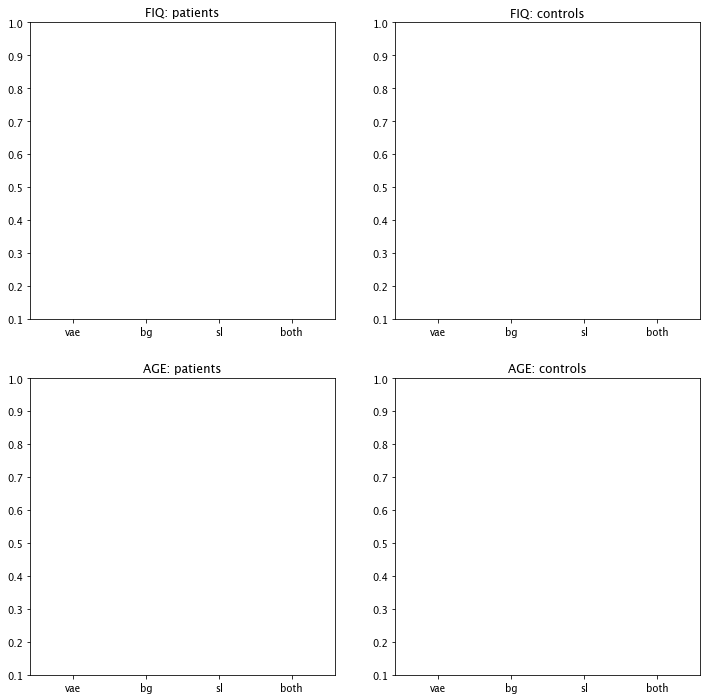

In [74]:
plt.figure(figsize=(12,12))
print(bv.keys())

plt.subplot(2,2,1);vv = (patients*~np.isnan(df['FIQ'].values))*(df['AgeAtScan'].values<20);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ: patients')
plt.ylim(.1,1)
plt.subplot(2,2,2);vv = controls*~np.isnan(df['FIQ'].values);y = df['FIQ'].values[vv];fit_reg(y,vv);plt.title('FIQ: controls')
plt.ylim(.1,1)

plt.subplot(2,2,3);vv = (patients*df['AgeAtScan'].values < 12);y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE: patients')
plt.ylim(.1,1)
plt.subplot(2,2,4);vv = (controls*df['AgeAtScan'].values > 18)*df['Sex'].values==1;y = df['AgeAtScan'].values[vv];fit_reg(y,vv);plt.title('AGE: controls')
plt.ylim(.1,1)

### Using regression to predict continuus variables is unsucessfull so far

### Next Steps / To Do's

## Figure out what is going on with the spaces, VAE not being sensitive to scanner effects seems like a bug. There's no structure in the background space either (euclidean distance plots)

## Tackle RNG, when I re-run the results, the bar plots, numner of clusters in from the BNP changes, maybe investigate mode instead of the samples instead

## Train the VAEs some more, these were trained on colab, maybe decent training on andromeda will help

import sklearn

In [75]:
import sklearn
import scipy
linkage = scipy.cluster.hierarchy.linkage
mutual_info = sklearn.metrics.normalized_mutual_info_score
#mutual_info = sklearn.metrics.mutual_info_score

In [76]:
keys = ['center', 'scanner', 'head_sizez', 'DSMIVTR', 'fiq', 'gender', 'agesz', 'diag']

In [77]:
def make_good_vec(vec):
#np.float64
#np.int64
#np.str_
    if type(vec[0])==np.str_: # MAKE NUM
        vec = numerize(vec)
    elif type(vec[0])==np.float64: # BIN
        nbins = 5
        #vec = bv['fiq']
        vec = np.digitize(vec,np.linspace(vec.min(),vec.max(),nbins))
        
    return vec #(vec-vec.mean())/vec.std()

In [78]:
mat = np.array([make_good_vec(bv[key]) for key in keys]);
mat = mat[:,all_subs]

In [79]:
n = len(keys)
mimat = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        mimat[i,j] = mutual_info(mat[i,:],mat[j,:])

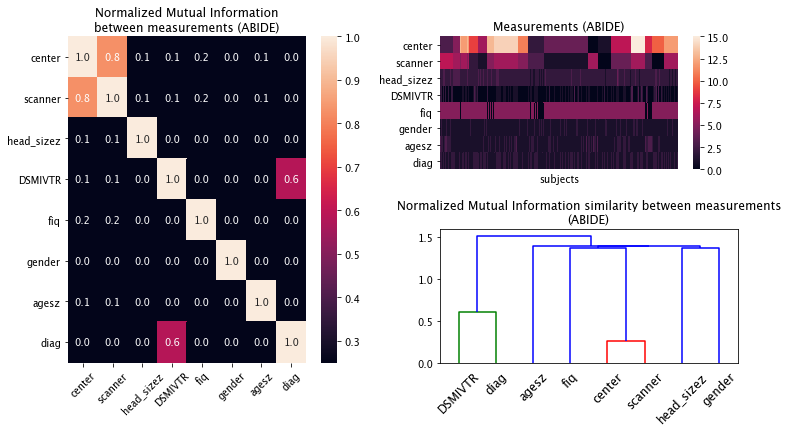

In [80]:
plt.figure(figsize=np.array((12,6))*1  )

plt.subplot(1,2,1)
sns.heatmap(mimat,annot=True,
    vmin=.25,
    vmax=1,
    cmap=None,
    center=None,
    robust=False,
    fmt='.1f',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None)

plt.xticks(np.arange(n)+.5,keys,rotation=45);
plt.yticks(np.arange(n)+.5,keys,rotation=0);
plt.title('Normalized Mutual Information\nbetween measurements (ABIDE)');

plt.subplot(2,2,2)

sns.heatmap(mat);
plt.yticks(np.arange(n)+.5,keys,rotation=0);
plt.xticks([]);
plt.title('Measurements (ABIDE)');
plt.xlabel('subjects')


plt.subplot(2,2,4)
d = scipy.cluster.hierarchy.dendrogram(linkage(pdist(1-mimat)),labels=keys,leaf_rotation=45)
plt.title('Normalized Mutual Information similarity between measurements\n(ABIDE)');

plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.25,
    hspace= .45)

### Mutual information between measurements: center and scanner does not have a lot of mutual information with other measurements

In [335]:
cross_val_score = sklearn.model_selection.cross_val_score
#clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform',algorithm='auto',leaf_size=30,p=2,metric='euclidean',metric_params=None,n_jobs=None)
#clf = sklearn.svm.SVC(decision_function_shape='ovo')

c = 1.00; g = 'scale'
#c = 10; g = 'scale'
clf = sklearn.svm.SVC(C=c,kernel='rbf',degree=1,gamma=g,coef0=0.0,shrinking=True,probability=False,tol=0.001,cache_size=200,class_weight=None,verbose=False,max_iter=-1,decision_function_shape='ovr',break_ties=False,random_state=None)
## When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected

In [336]:
X = mat[0::,patients].transpose()
ncv = 5
Y = cid_bg
scores_bg = cross_val_score(clf, X, Y, cv=ncv)
Y = cid_sl
scores_sl = cross_val_score(clf, X, Y, cv=ncv)
Y = cid_vae
scores_vae = cross_val_score(clf, X, Y, cv=ncv)

xs = np.arange(3)
arrs = [scores_bg,scores_sl,scores_vae]

In [337]:
collect1,collect2,collect3 = list(),list(),list()

for i in range(n):
    slice_ = np.repeat(True,n)
    slice_[i]=False
    X = mat[slice_,:][:,patients].transpose()
    
    scores_bg = cross_val_score(clf, X, cid_bg, cv=ncv)
    scores_sl = cross_val_score(clf, X, cid_sl, cv=ncv)
    scores_vae = cross_val_score(clf, X, cid_vae, cv=ncv)
    
    collect1.append(scores_bg)
    collect2.append(scores_sl)
    collect3.append(scores_vae)

In [338]:
arr1 = 1-np.array([col.mean() for col in collect1])
arr2 = 1-np.array([col.mean() for col in collect2])
arr3 = 1-np.array([col.mean() for col in collect3])

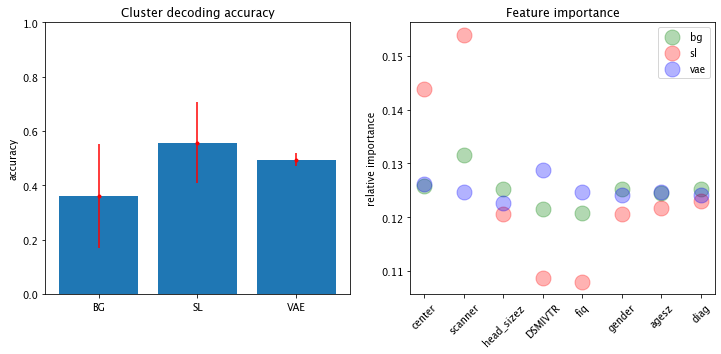

In [340]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(xs,np.array([arr.mean() for arr in arrs]));
plt.errorbar(xs,np.array([arr.mean() for arr in arrs]), np.array([arr.std() for arr in arrs]),fmt='r.');
plt.xticks([0,1,2],['BG','SL','VAE']);
plt.ylim(0,1);
plt.title('Cluster decoding accuracy');
plt.ylabel('accuracy');


plt.subplot(1,2,2)
plt.plot(arr1/arr1.sum(),'g.',markersize=30,alpha=.3); # BG
plt.plot(arr2/arr2.sum(),'r.',markersize=30,alpha=.3); # SL
plt.plot(arr3/arr3.sum(),'b.',markersize=30,alpha=.3); # VAE

plt.legend(['bg','sl','vae']);
plt.xticks(range(n),keys,rotation=45);
plt.title('Feature importance');
plt.ylabel('relative importance');

In [312]:
###

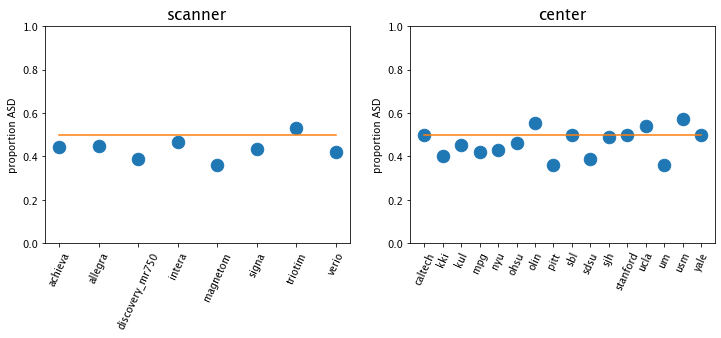

In [313]:
df['center'] = bv['center']
df['scanner'] = bv['scanner']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
str_ = 'scanner'
u = np.unique(df[str_].values)
l = list()
xs = np.arange(len(u))
for i in xs:
    v1 = df[str_].values==u[i]
    v2 = df['Subject Type'].values[v1]=='PATIENT'
    l.append(v2.sum()/v1.sum())
    
plt.plot(l,'.',markersize=25)
plt.plot(xs,np.repeat(.5,len(u)))
plt.ylim(0,1);
plt.title(str_,fontsize=16);
plt.ylabel('proportion ASD');
u[4] = 'magnetom'
plt.xticks(xs,u,rotation=65);


plt.subplot(1,2,2)

str_ = 'center'
u = np.unique(df[str_].values)
l = list()
xs = np.arange(len(u))
for i in xs:
    v1 = df[str_].values==u[i]
    v2 = df['Subject Type'].values[v1]=='PATIENT'
    l.append(v2.sum()/v1.sum())
    
plt.plot(l,'.',markersize=25)
plt.plot(xs,np.repeat(.5,len(u)))
plt.ylim(0,1);
plt.title(str_,fontsize=16);
plt.ylabel('proportion ASD');
plt.xticks(xs,u,rotation=65);